In [1]:
!rm save*/*


In [2]:
random_seed = 657


In [3]:
import pandas as pd
import numpy as np
from IPython.display import display, Image, HTML, Markdown
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
import joblib


### LOAD AND PREPARE DATASET

In [4]:
dataset_path = 'ds_challenge_data_2022.csv'
with open(dataset_path, 'rb') as file:
    df = pd.read_csv(dataset_path, encoding='utf-16')


In [5]:
def extract_field_from_json(json_string, field):
    try:
        json_data = json.loads(json_string.replace("'", '"'))
        return json_data.get(field, None)
    except json.JSONDecodeError:
        return None


# Extract device brand -> dispositivo_marca
df['dispositivo_marca'] = df['dispositivo'].apply(lambda x: extract_field_from_json(x, 'marca'))

# Create an id for the user device
df['dispositivo_id'] = df['dispositivo'].apply(lambda x: extract_field_from_json(x, 'año')).astype(str)
df['dispositivo_id'] += df['dispositivo_marca']

# Extract isp -> dispositivo_proveedor
df['dispositivo_proveedor'] = df['dispositivo'].apply(lambda x: extract_field_from_json(x, 'proveedor'))


In [6]:
def get_commulative_features(user_df):
  # n_user_transactions
  user_df['n_user_transactions'] = np.arange(user_df.shape[0])


  # n_dispositivos_acumulados
  values = []
  for index, row in user_df.iterrows():
      values.append(len(user_df.loc[:index, 'dispositivo_id'].unique()))
  user_df['n_dispositivos_acumulados'] = values

  # has_previous_fraud
  values = []
  for index, row in user_df.iterrows():
      if len(values) == 0:
        values.append(False)
      else:
        values.append(user_df.loc[:index-1, 'fraude'].max())
  user_df['has_previous_fraud'] = values


  # device used_before
  values = []
  for index, row in user_df.iterrows():
      values.append((user_df.loc[:index, 'dispositivo_id'] == user_df.loc[index, 'dispositivo_id']).sum() -1)

  user_df['device_used_before'] = values
  user_df['device_used_before'] = user_df['device_used_before'].astype(bool)

  return(user_df)




In [7]:
df_features = df.groupby('user_id').apply(get_commulative_features)

<ipython-input-7-a5ab097d1d63>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_features = df.groupby('user_id').apply(get_commulative_features)


### Descriptive Analisis

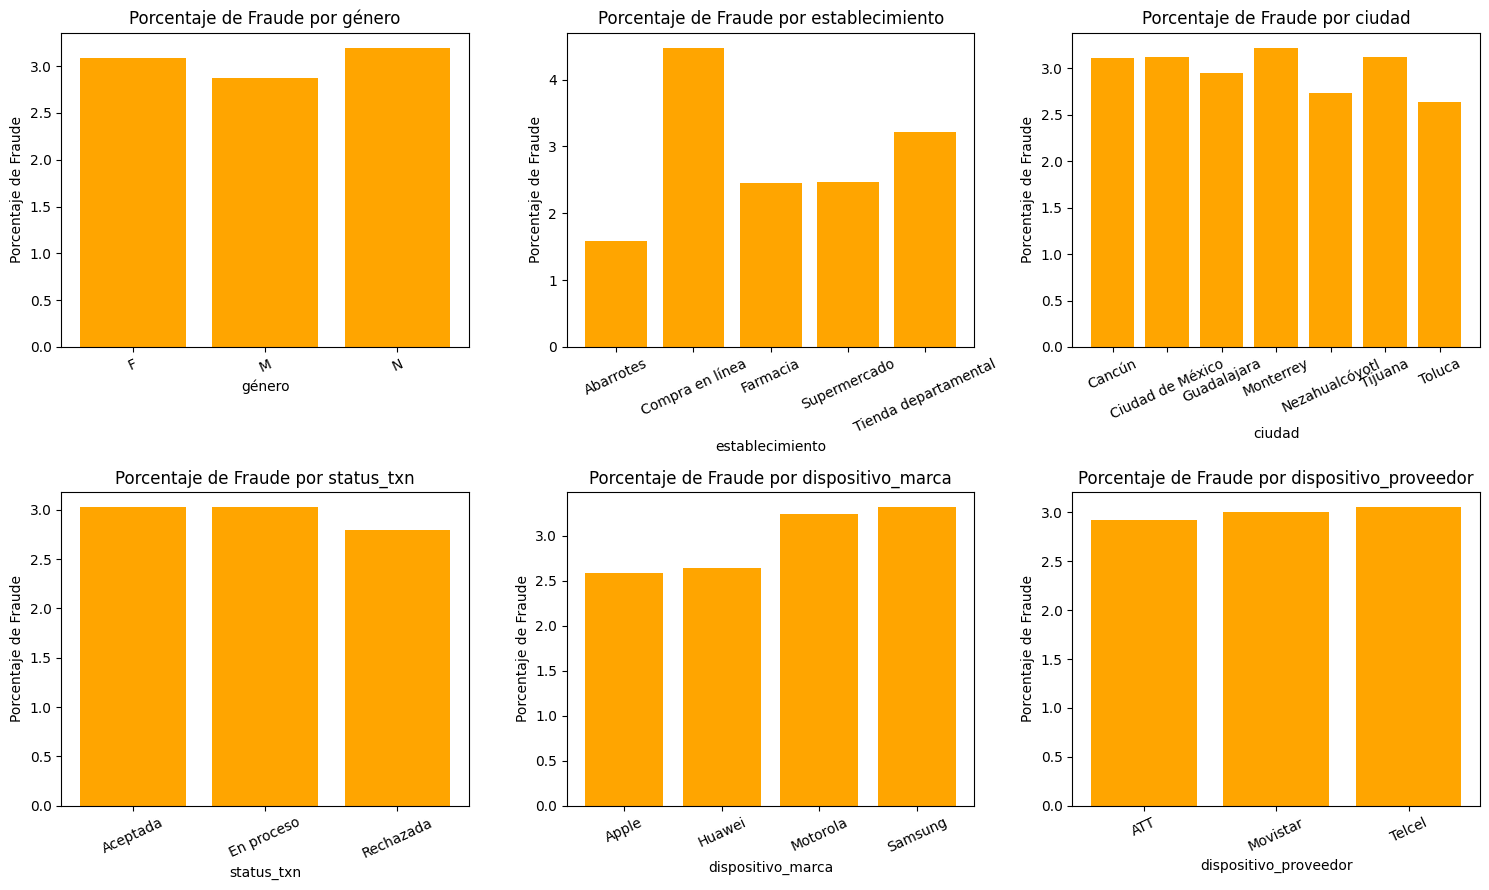

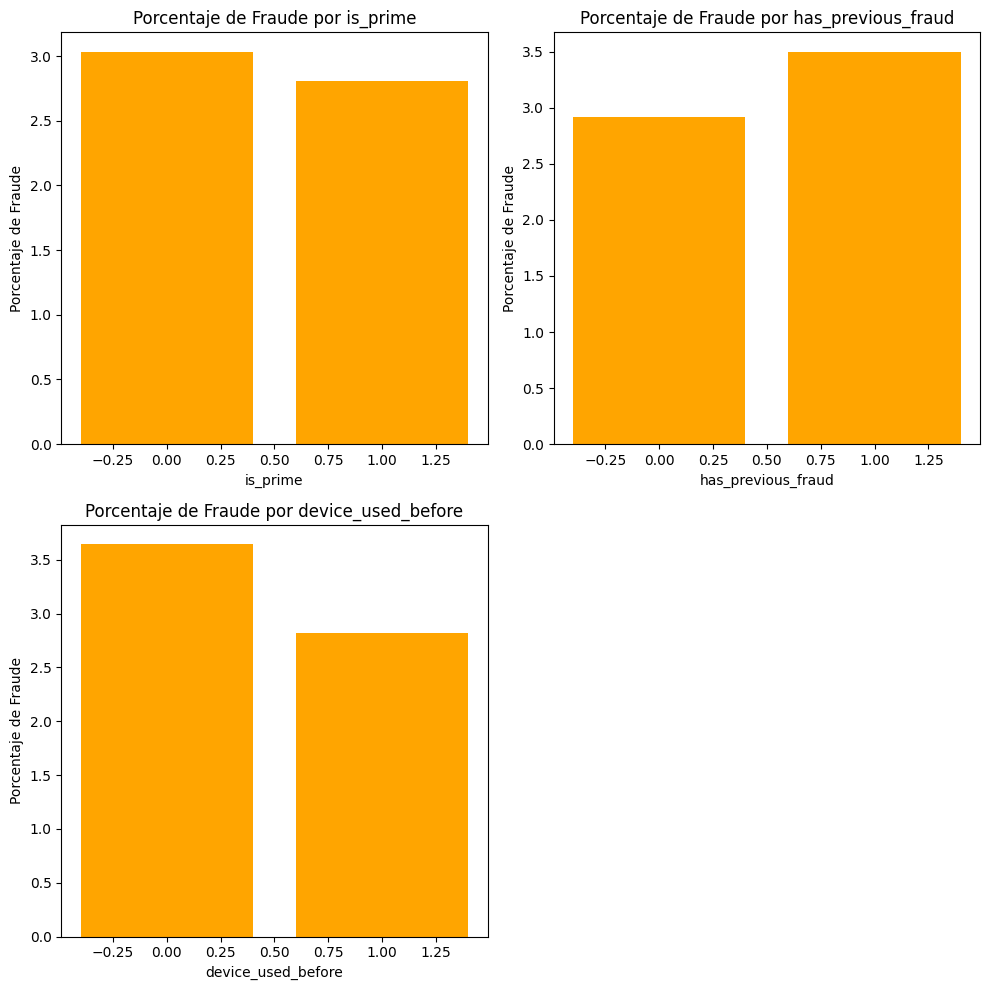

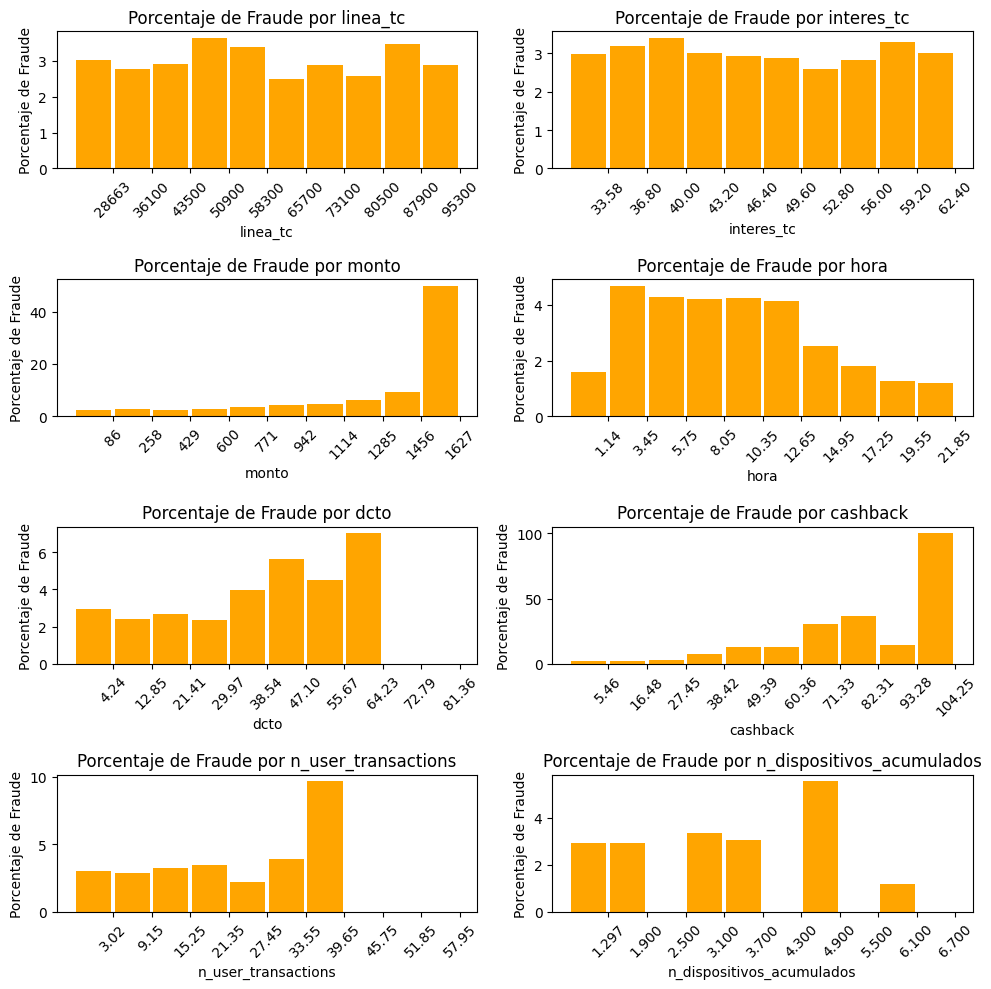

In [8]:
import matplotlib.pyplot as plt

categorical_variables = ['género', 'establecimiento', 'ciudad', 'status_txn', 'dispositivo_marca', 'dispositivo_proveedor']
binary_variables = ['is_prime', 'has_previous_fraud', 'device_used_before', 'fraude']
numerical_variables = ['linea_tc', 'interes_tc', 'monto', 'hora', 'dcto', 'cashback', 'n_user_transactions', 'n_dispositivos_acumulados']

# Create a matrix of subplots for categorical variables
num_cols = 3  # Number of columns in the matrix
num_rows = (len(categorical_variables) + 1) // num_cols  # Number of rows in the matrix
plt.figure(figsize=(15, 9))

for i, col in enumerate(categorical_variables):
    plt.subplot(num_rows, num_cols, i + 1)
    df_grouped = df_features.groupby([col])['fraude'].mean().reset_index()
    plt.bar(df_grouped[col], df_grouped['fraude'] * 100,color='orange')
    plt.xlabel(col)
    plt.ylabel('Porcentaje de Fraude')
    plt.title(f'Porcentaje de Fraude por {col}')
    plt.xticks(rotation=25)

plt.tight_layout()
plt.show()

# Create a matrix of subplots for binary variables
num_cols = 2  # Number of columns in the matrix

binary_variables
num_rows = (len(binary_variables[:-1]) + 1) // 2  # Number of rows in the matrix
plt.figure(figsize=(10, 10))

for i, col in enumerate(binary_variables[:-1]):
    plt.subplot(num_rows, num_cols, i + 1)
    df_grouped = df_features.groupby([col])['fraude'].mean().reset_index()
    plt.bar(df_grouped[col], df_grouped['fraude'] * 100,color='orange')
    plt.xlabel(col)
    plt.ylabel('Porcentaje de Fraude')
    plt.title(f'Porcentaje de Fraude por {col}')

plt.tight_layout()
plt.show()



# Create a matrix of subplots for numerical variables
num_cols = 2  # Number of columns in the matrix
num_rows = (len(numerical_variables) + 1) // 2  # Number of rows in the matrix
plt.figure(figsize=(10, 10))

for i, col in enumerate(numerical_variables):
    if col != 'fraude':
        plt.subplot(num_rows, num_cols, i + 1)
        df_grouped = df_features.groupby(pd.cut(df_features[col], bins=10))[['fraude']].mean().reset_index()
        plt.bar(
            df_grouped[col].apply(lambda interval: interval.left),
            df_grouped['fraude'] * 100,
            width=df_grouped.loc[0, col].length * 0.9,
            color='orange'
        )
        plt.xlabel(col)
        plt.ylabel('Porcentaje de Fraude')
        plt.title(f'Porcentaje de Fraude por {col}')
        plt.xticks(df_grouped[col].apply(lambda interval: interval.mid), rotation=45)

plt.tight_layout()
plt.show()



### Prepare Data for Modeling

In [9]:
# Train / Test split (use new transactions as test)
train_test_split = .8

all_users = df_features['user_id'].unique()
np.random.shuffle(all_users)

df_train = df_features[df_features['user_id'].isin(all_users[:int(len(all_users)*train_test_split)])]
df_test = df_features[df_features['user_id'].isin(all_users[int(len(all_users)*train_test_split):])]


In [10]:


# Columns for training
categorical_columns = ['género', 'establecimiento', 'ciudad', 'status_txn', 'dispositivo_marca', 'dispositivo_proveedor']
binary_columns = ['is_prime', 'has_previous_fraud', 'device_used_before']
numerical_columns = ['linea_tc', 'interes_tc', 'monto', 'hora', 'dcto', 'cashback', 'n_user_transactions', 'n_dispositivos_acumulados']

all_columns = categorical_columns+binary_columns+numerical_columns+['fraude']
df_train = df_train[all_columns]
df_test = df_test[all_columns]

In [11]:
model_save_dir = "saved_models/"

In [12]:
# One-Hot Encoding for categorical variables
df_train_encoded = pd.get_dummies(df_train, columns=categorical_columns)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_columns)

# Ensure that df_train_encoded and df_test_encoded have the same columns
common_columns = set(df_train_encoded.columns) & set(df_test_encoded.columns)
missing_columns_train = set(df_test_encoded.columns) - set(df_train_encoded.columns)
missing_columns_test = set(df_train_encoded.columns) - set(df_test_encoded.columns)

# Add missing columns with all zeros
for col in missing_columns_train:
    df_train_encoded[col] = 0

for col in missing_columns_test:
    df_test_encoded[col] = 0




# Normalization of numerical variables
scaler = StandardScaler()
df_train_encoded[numerical_columns] = scaler.fit_transform(df_train_encoded[numerical_columns])
df_test_encoded[numerical_columns] = scaler.transform(df_test_encoded[numerical_columns])
scaler_filename = f"{model_save_dir}scaler.pkl"
joblib.dump(scaler, scaler_filename)

# Convert binary variables to numeric
df_train_encoded[binary_columns] = df_train_encoded[binary_columns].astype(int)
df_test_encoded[binary_columns] = df_test_encoded[binary_columns].astype(int)


# Apply oversampling to address class imbalance
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=random_seed)
X_train_resampled, y_train_resampled = oversampler.fit_resample(df_train_encoded.drop('fraude', axis=1), df_train_encoded['fraude'])


In [13]:

# Train and evaluate multiple models
models = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed),
    "AdaBoost": AdaBoostClassifier(random_state=random_seed),
    "SVM": SVC(random_state=random_seed),
    "Neural Network": MLPClassifier(random_state=random_seed, max_iter=500)
}


for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = model.predict(df_test_encoded.drop('fraude', axis=1))

    # Evaluate the model on df_test
    accuracy = accuracy_score(df_test_encoded['fraude'], y_pred)
    precision = precision_score(df_test_encoded['fraude'], y_pred)
    recall = recall_score(df_test_encoded['fraude'], y_pred)
    f1 = f1_score(df_test_encoded['fraude'], y_pred)
    confusion = confusion_matrix(df_test_encoded['fraude'], y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{confusion}\n")

    # Save the trained model to a file
    model_filename = f"{model_save_dir}{model_name}_model.pkl"
    joblib.dump(model, model_filename)



Model: Random Forest
Accuracy: 0.9703868221358505
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[5243    1]
 [ 159    0]]

Model: Gradient Boosting
Accuracy: 0.7693873773829354
Precision: 0.06762132060461416
Recall: 0.5345911949685535
F1 Score: 0.12005649717514126
Confusion Matrix:
[[4072 1172]
 [  74   85]]

Model: AdaBoost
Accuracy: 0.7009069035720896
Precision: 0.05768063145112325
Recall: 0.5974842767295597
F1 Score: 0.10520487264673312
Confusion Matrix:
[[3692 1552]
 [  64   95]]

Model: SVM
Accuracy: 0.8656302054414214
Precision: 0.06046511627906977
Recall: 0.24528301886792453
F1 Score: 0.09701492537313433
Confusion Matrix:
[[4638  606]
 [ 120   39]]

Model: Neural Network
Accuracy: 0.9428095502498612
Precision: 0.09239130434782608
Recall: 0.1069182389937107
F1 Score: 0.09912536443148688
Confusion Matrix:
[[5077  167]
 [ 142   17]]



In [14]:
import json

# Create a dictionary to store encoding information
encoding_info = {
    'categorical_columns': categorical_columns,
    'encoded_columns': list(df_train_encoded.columns)
}

# Save the encoding information to a JSON file
with open('encoding_info.json', 'w') as file:
    json.dump(encoding_info, file)


In [15]:
!zip -r saved_models.zip saved_models


  adding: saved_models/ (stored 0%)
  adding: saved_models/Neural Network_model.pkl (deflated 9%)
  adding: saved_models/Gradient Boosting_model.pkl (deflated 65%)
  adding: saved_models/SVM_model.pkl (deflated 88%)
  adding: saved_models/scaler.pkl (deflated 29%)
  adding: saved_models/AdaBoost_model.pkl (deflated 77%)
  adding: saved_models/Random Forest_model.pkl (deflated 79%)
  adding: saved_models/.ipynb_checkpoints/ (stored 0%)
